# Cricket Feature Engineering

This notebook engineers cricket-specific features for the training and test datasets to improve model performance for match outcome prediction.

Objectives:
- Define cricket-aware features (e.g., run rates, wickets in hand, phase of chase)
- Apply the transformations consistently to train and test
- Save engineered datasets for modeling
- Quick profiling and optional feature importance


In [1]:
# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (8, 5)

# Paths
BASE_DIR = Path.cwd().parents[0]
DATA_TRAIN = BASE_DIR / 'cricket_dataset.csv'
DATA_TEST = BASE_DIR / 'cricket_dataset_test.csv'
OUTPUT_DIR = BASE_DIR / 'feature-engineering'
OUTPUT_DIR.mkdir(exist_ok=True)

DATA_TRAIN, DATA_TEST, OUTPUT_DIR


(WindowsPath('c:/Users/Admin/Desktop/Ahsham/cricket-prediction-task/cricket_dataset.csv'),
 WindowsPath('c:/Users/Admin/Desktop/Ahsham/cricket-prediction-task/cricket_dataset_test.csv'),
 WindowsPath('c:/Users/Admin/Desktop/Ahsham/cricket-prediction-task/feature-engineering'))

In [2]:
# Load data
train_df = pd.read_csv(DATA_TRAIN)
test_df = pd.read_csv(DATA_TEST)

print('Train shape:', train_df.shape)
print('Test shape :', test_df.shape)
train_df.head()


Train shape: (15691, 5)
Test shape : (627, 4)


,total_runs,wickets,target,balls_left,won
0,0.0,0.0,125,119.0,1
1,0.0,0.0,125,118.0,1
2,1.0,0.0,125,117.0,1
3,1.0,1.0,125,116.0,1
4,1.0,1.0,125,115.0,1


In [3]:
# Cricket-specific feature engineering

def add_cricket_features(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    out = df.copy()

    # Basic sanity caps (avoid divide-by-zero and unrealistic values)
    out['wickets'] = out['wickets'].clip(lower=0, upper=10)
    out['balls_left'] = out['balls_left'].clip(lower=0, upper=120)

    # Derived cricket features
    # - Overs left (T20 chase assumed 120 balls)
    out['overs_left'] = out['balls_left'] / 6.0

    # - Wickets in hand
    out['wickets_in_hand'] = 10 - out['wickets']

    # - Current run rate (CRR): runs scored so far per over faced
    #   overs_faced = 20 - overs_left = (120 - balls_left)/6
    overs_faced = (120 - out['balls_left']) / 6.0
    out['current_run_rate'] = np.where(overs_faced > 0, out['total_runs'] / overs_faced, 0.0)

    # - Required runs
    out['required_runs'] = np.maximum(out['target'] - out['total_runs'], 0)

    # - Required run rate (RRR): runs needed per over remaining
    out['required_run_rate'] = np.where(out['overs_left'] > 0, out['required_runs'] / out['overs_left'], np.inf)

    # - Run rate differential: CRR - RRR (positive means ahead of rate)
    out['run_rate_diff'] = out['current_run_rate'] - out['required_run_rate']

    # - Pressure proxy: wickets_in_hand * overs_left (resource-like)
    out['resources_proxy'] = out['wickets_in_hand'] * out['overs_left']

    # - Required runs per ball
    out['req_per_ball'] = np.where(out['balls_left'] > 0, out['required_runs'] / out['balls_left'], np.inf)

    # - Chase phase indicators
    out['is_powerplay'] = (overs_faced <= 6).astype(int)
    out['is_middle_overs'] = ((overs_faced > 6) & (overs_faced <= 15)).astype(int)
    out['is_death_overs'] = (overs_faced > 15).astype(int)

    # - Tight chase indicator: small margin remaining
    out['tight_chase'] = ((out['required_runs'] <= 20) & (out['overs_left'] <= 4)).astype(int)

    # - Safety checks for infinities
    numeric_cols = out.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        out[col] = out[col].replace([np.inf, -np.inf], np.nan)

    # - Interaction terms
    out['rrr_over_wickets'] = np.where(out['wickets_in_hand'] > 0, out['required_run_rate'] / out['wickets_in_hand'], np.nan)
    out['rr_diff_times_wi'] = out['run_rate_diff'] * out['wickets_in_hand']

    # - Normalize some rates per wicket left
    out['crr_over_wickets'] = np.where(out['wickets_in_hand'] > 0, out['current_run_rate'] / out['wickets_in_hand'], np.nan)

    # Keep target if present
    if is_train and 'won' in out.columns:
        cols = ['won'] + [c for c in out.columns if c != 'won']
        out = out[cols]

    return out

train_fe = add_cricket_features(train_df, is_train=True)
test_fe = add_cricket_features(test_df, is_train=False)

train_fe.head()


,won,total_runs,wickets,target,balls_left,overs_left,wickets_in_hand,current_run_rate,required_runs,required_run_rate,run_rate_diff,resources_proxy,req_per_ball,is_powerplay,is_middle_overs,is_death_overs,tight_chase,rrr_over_wickets,rr_diff_times_wi,crr_over_wickets
0,1,0.0,0.0,125,119.0,19.833333,10.0,0.0,125.0,6.302521,-6.302521,198.333333,1.050420,1,0,0,0,0.630252,-63.025210,0.000000
1,1,0.0,0.0,125,118.0,19.666667,10.0,0.0,125.0,6.355932,-6.355932,196.666667,1.059322,1,0,0,0,0.635593,-63.559322,0.000000
2,1,1.0,0.0,125,117.0,19.500000,10.0,2.0,124.0,6.358974,-4.358974,195.000000,1.059829,1,0,0,0,0.635897,-43.589744,0.200000
3,1,1.0,1.0,125,116.0,19.333333,9.0,1.5,124.0,6.413793,-4.913793,174.000000,1.068966,1,0,0,0,0.712644,-44.224138,0.166667
4,1,1.0,1.0,125,115.0,19.166667,9.0,1.2,124.0,6.469565,-5.269565,172.500000,1.078261,1,0,0,0,0.718841,-47.426087,0.133333


In [4]:
# Save engineered datasets
train_out = OUTPUT_DIR / 'cricket_dataset_engineered.csv'
test_out = OUTPUT_DIR / 'cricket_dataset_test_engineered.csv'

train_fe.to_csv(train_out, index=False)
test_fe.to_csv(test_out, index=False)

print('Saved:')
print(train_out)
print(test_out)


Saved:
c:\Users\Admin\Desktop\Ahsham\cricket-prediction-task\feature-engineering\cricket_dataset_engineered.csv
c:\Users\Admin\Desktop\Ahsham\cricket-prediction-task\feature-engineering\cricket_dataset_test_engineered.csv


New feature columns: ['overs_left', 'wickets_in_hand', 'current_run_rate', 'required_runs', 'required_run_rate', 'run_rate_diff', 'resources_proxy', 'req_per_ball', 'is_powerplay', 'is_middle_overs', 'is_death_overs', 'tight_chase', 'rrr_over_wickets', 'rr_diff_times_wi', 'crr_over_wickets']


,count,mean,std,min,25%,50%,75%,max
overs_left,15689.0,10.627913,5.500757,0.000000,6.000000,10.833333,15.333333,19.833333
wickets_in_hand,15689.0,7.461470,2.153691,0.000000,6.000000,8.000000,9.000000,10.000000
current_run_rate,15691.0,7.477334,2.382193,0.000000,6.217525,7.466667,8.666667,36.000000
required_runs,15689.0,85.350245,48.311553,0.000000,46.000000,83.000000,122.000000,238.000000
required_run_rate,15641.0,9.030462,10.134750,0.000000,6.258621,8.000000,9.913043,402.000000
run_rate_diff,15641.0,-1.553191,10.492857,-396.302521,-3.456622,-0.746606,1.862011,29.445378
resources_proxy,15689.0,88.319863,58.374829,0.000000,36.666667,81.666667,136.000000,198.333333
req_per_ball,15641.0,1.505077,1.689125,0.000000,1.043103,1.333333,1.652174,67.000000
is_powerplay,15691.0,0.329679,0.470112,0.000000,0.000000,0.000000,1.000000,1.000000
is_middle_overs,15691.0,0.474858,0.499383,0.000000,0.000000,0.000000,1.000000,1.000000


Correlation with target (won):
rr_diff_times_wi     0.381396
wickets_in_hand      0.291894
run_rate_diff        0.290300
resources_proxy      0.110929
current_run_rate     0.095906
tight_chase          0.090631
overs_left           0.058931
is_powerplay         0.029796
is_middle_overs      0.020405
is_death_overs      -0.060619
rrr_over_wickets    -0.167891
crr_over_wickets    -0.217597
required_runs       -0.246615
required_run_rate   -0.277977
req_per_ball        -0.277977
Name: won, dtype: float64


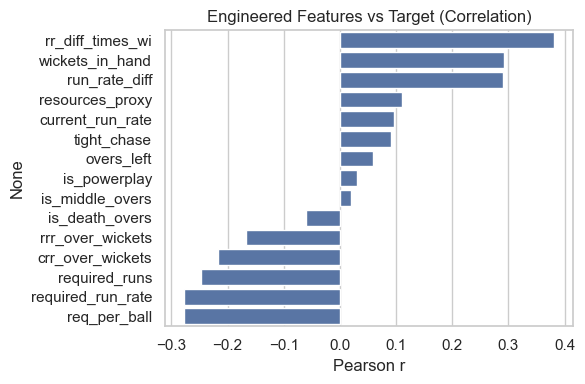

In [5]:
# Quick profiling of engineered features
basic_cols = ['total_runs','wickets','target','balls_left']
new_cols = [c for c in train_fe.columns if c not in basic_cols + ['won']]

print('New feature columns:', new_cols)

display(train_fe[new_cols].describe().T)

# Pairwise correlations of engineered features with target
if 'won' in train_fe.columns:
    corrs = train_fe[['won'] + new_cols].corr().loc[new_cols, 'won'].sort_values(ascending=False)
    print('Correlation with target (won):')
    print(corrs)
    plt.figure(figsize=(6,4))
    sns.barplot(x=corrs.values, y=corrs.index, orient='h')
    plt.title('Engineered Features vs Target (Correlation)')
    plt.xlabel('Pearson r')
    plt.tight_layout()
    plt.show()


Validation ROC AUC: 0.9910


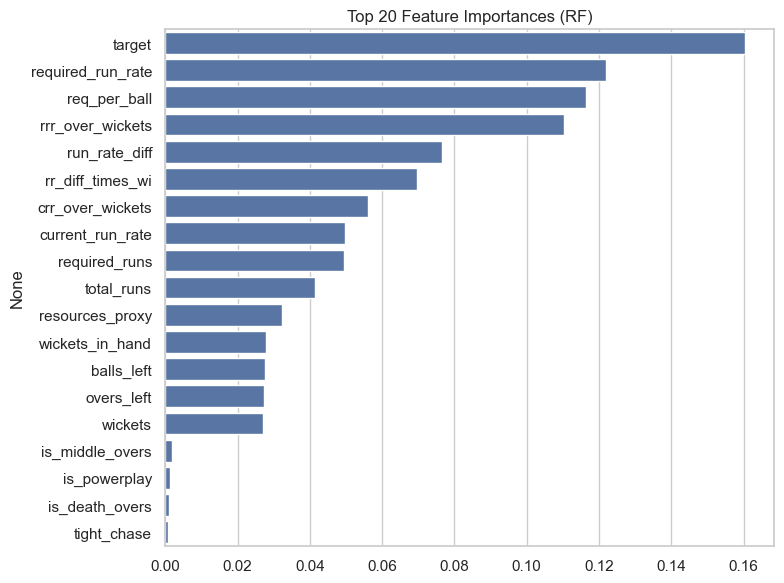

In [6]:
# Optional: quick feature importance (requires scikit-learn)
try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score
    from sklearn.ensemble import RandomForestClassifier

    if 'won' in train_fe.columns:
        X = train_fe.drop(columns=['won'])
        y = train_fe['won'].astype(int)
        X = X.fillna(X.median(numeric_only=True))
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight='balanced_subsample')
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_valid)[:,1]
        auc = roc_auc_score(y_valid, pred)
        print(f'Validation ROC AUC: {auc:.4f}')

        importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
        plt.figure(figsize=(8,6))
        sns.barplot(x=importances.values[:20], y=importances.index[:20], orient='h')
        plt.title('Top 20 Feature Importances (RF)')
        plt.tight_layout()
        plt.show()
    else:
        print('Target column `won` not found; skipping importance.')
except Exception as e:
    print('Skipped importance due to error/missing sklearn:', e)


## Features Added and Rationale

- overs_left: Remaining overs; lower overs increase pressure on the chase.
- wickets_in_hand: Resource for acceleration; more wickets enable higher risk batting.
- current_run_rate (CRR): Momentum measure of batting so far.
- required_runs: Remaining runs to win; basic progress metric.
- required_run_rate (RRR): Difficulty of the chase given remaining overs.
- run_rate_diff (CRR - RRR): Ahead/behind the rate, classic chase indicator.
- resources_proxy (wickets_in_hand × overs_left): Simple proxy for Duckworth–Lewis–like resources.
- req_per_ball: Granular pressure indicator; high values indicate steep chase.
- is_powerplay / is_middle_overs / is_death_overs: Phase effects change field settings and risk appetite.
- tight_chase: Late-game pressure heuristic (<= 20 runs with <= 4 overs left).
- rrr_over_wickets: Balances required rate by wickets remaining (pressure per wicket).
- rr_diff_times_wi: Interaction of being ahead/behind rate modulated by wickets left.
- crr_over_wickets: Normalizes current rate by wickets left (efficiency vs resources).

All features are computed for both train and test with the same logic and saved under `feature-engineering/` as engineered CSVs.
